In [92]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import datetime
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, SeparableConv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from sklearn.metrics import classification_report, recall_score, precision_score, confusion_matrix, f1_score, accuracy_score
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
import itertools


In [65]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import itertools
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, SeparableConv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from sklearn.metrics import classification_report, recall_score, precision_score, confusion_matrix, f1_score, accuracy_score
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50


In [66]:
data_dir = '/kaggle/input/lc2500/lung_image_sets'


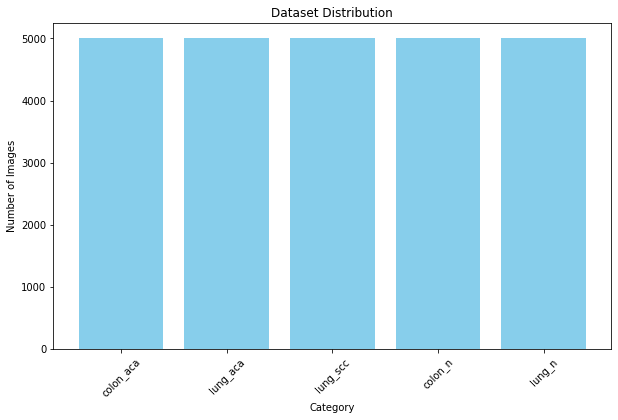

In [67]:
def visualize_data_distribution(data_dir):
    categories = os.listdir(data_dir)
    category_counts = {category: len(os.listdir(os.path.join(data_dir, category))) for category in categories}
    
    plt.figure(figsize=(10, 6))
    plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
    plt.title('Dataset Distribution')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

visualize_data_distribution(data_dir)


In [68]:
train_datagen_resnet = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

train_generator_resnet = train_datagen_resnet.flow_from_directory(
        '/kaggle/input/lc2500/lung_image_sets',
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical',
        subset='training'
        )

Found 20000 images belonging to 5 classes.


In [69]:
val_datagen_resnet = ImageDataGenerator(rescale=1./255)

val_generator_resnet = train_datagen_resnet.flow_from_directory(
        '/kaggle/input/lc2500/lung_image_sets',
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical',
        subset='validation'
        )

Found 5000 images belonging to 5 classes.


In [70]:
test_datagen_resnet = ImageDataGenerator(rescale=1./255)

test_generator_resnet = test_datagen_resnet.flow_from_directory(
        '/kaggle/input/lc2500/lung_image_sets',
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical')

Found 25000 images belonging to 5 classes.


In [71]:
def visualize_sample_images(generator):
    class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(15, 10))
    
    for i, class_name in enumerate(class_names):
        folder_path = os.path.join(generator.directory, class_name)
        image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
        
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img_array)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

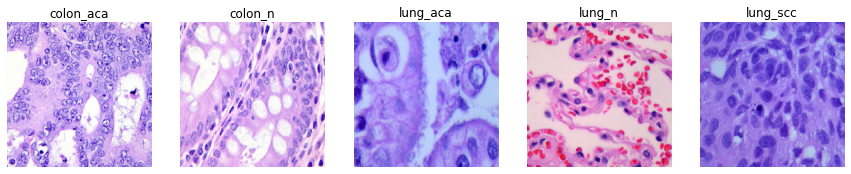

In [72]:

visualize_sample_images(train_generator_resnet)

In [73]:
from keras.applications.resnet50 import ResNet50

In [74]:
rn50=ResNet50(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')

for layer in rn50.layers:
    layer.trainable=False

In [75]:
last_layer=rn50.layers[-1]
last_output = last_layer.output

In [76]:
x=layers.GlobalAveragePooling2D()(last_output)
x=layers.Dense(5,activation='softmax')(x)
resnet50=keras.Model(rn50.input,x)

In [77]:
resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [78]:
resnet50.compile(optimizer='adam',
              loss='categorical_crossentropy',
               metrics=['accuracy',Precision(),Recall()])

In [79]:
history_resnet=resnet50.fit_generator(train_generator_resnet,validation_data=val_generator_resnet,epochs=60,verbose=2)

Epoch 1/60
157/157 - 476s - loss: 1.5042 - accuracy: 0.3911 - precision_1: 0.4490 - recall_1: 0.0011 - val_loss: 1.4155 - val_accuracy: 0.4900 - val_precision_1: 0.6250 - val_recall_1: 0.0030
Epoch 2/60
157/157 - 481s - loss: 1.3718 - accuracy: 0.4803 - precision_1: 0.6729 - recall_1: 0.0216 - val_loss: 1.3177 - val_accuracy: 0.5128 - val_precision_1: 0.7500 - val_recall_1: 0.0252
Epoch 3/60
157/157 - 482s - loss: 1.2924 - accuracy: 0.5344 - precision_1: 0.7460 - recall_1: 0.0542 - val_loss: 1.2563 - val_accuracy: 0.5500 - val_precision_1: 0.7461 - val_recall_1: 0.0676
Epoch 4/60
157/157 - 480s - loss: 1.2393 - accuracy: 0.5541 - precision_1: 0.7680 - recall_1: 0.0881 - val_loss: 1.2047 - val_accuracy: 0.5820 - val_precision_1: 0.8141 - val_recall_1: 0.1042
Epoch 5/60
157/157 - 475s - loss: 1.1968 - accuracy: 0.5767 - precision_1: 0.7693 - recall_1: 0.1222 - val_loss: 1.1692 - val_accuracy: 0.6112 - val_precision_1: 0.8169 - val_recall_1: 0.1294
Epoch 6/60
157/157 - 472s - loss: 1.1600

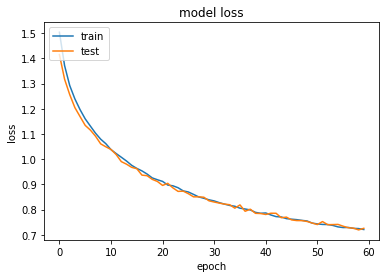

In [80]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

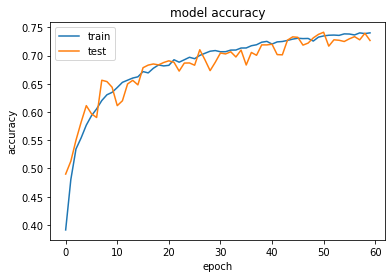

In [81]:
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

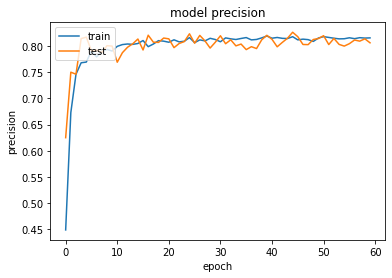

In [83]:
plt.plot(history_resnet.history['precision_1'])
plt.plot(history_resnet.history['val_precision_1'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

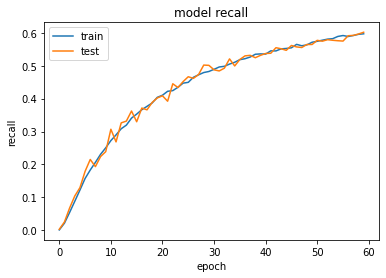

In [84]:
plt.plot(history_resnet.history['recall_1'])
plt.plot(history_resnet.history['val_recall_1'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [85]:
val_metrics = resnet50.evaluate(val_generator_resnet)
print(f'Validation Loss: {val_metrics[0]}')
print(f'Validation Accuracy: {val_metrics[1]}')
print(f'Validation Precision: {val_metrics[2]}')
print(f'Validation Recall: {val_metrics[3]}')


40/40 [==============================] - 92s 2s/step - loss: 0.7332 - accuracy: 0.7170 - precision_1: 0.7989 - recall_1: 0.5958
Validation Loss: 0.73323655128479
Validation Accuracy: 0.7170000076293945
Validation Precision: 0.7988736629486084
Validation Recall: 0.59579998254776


In [86]:
test_metrics = resnet50.evaluate(test_generator_resnet)
print(f'Testing Loss: {test_metrics[0]}')
print(f'Testing Accuracy: {test_metrics[1]}')
print(f'Testing Precision: {test_metrics[2]}')
print(f'Testing Recall: {test_metrics[3]}')


196/196 [==============================] - 271s 1s/step - loss: 0.7540 - accuracy: 0.7095 - precision_1: 0.7858 - recall_1: 0.6012
Testing Loss: 0.7540454864501953
Testing Accuracy: 0.7095199823379517
Testing Precision: 0.7858113646507263
Testing Recall: 0.6012399792671204


In [87]:
Y_pred = resnet50.predict(test_generator_resnet)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator_resnet.classes

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print(cm)

print('Classification Report')
target_names = list(test_generator_resnet.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


Confusion Matrix
[[1159 1347  549 1070  875]
 [1154 1318  567 1098  863]
 [1105 1346  532 1110  907]
 [1147 1247  557 1142  907]
 [1146 1249  573 1085  947]]
Classification Report
              precision    recall  f1-score   support

   colon_aca       0.20      0.23      0.22      5000
     colon_n       0.20      0.26      0.23      5000
    lung_aca       0.19      0.11      0.14      5000
      lung_n       0.21      0.23      0.22      5000
    lung_scc       0.21      0.19      0.20      5000

    accuracy                           0.20     25000
   macro avg       0.20      0.20      0.20     25000
weighted avg       0.20      0.20      0.20     25000



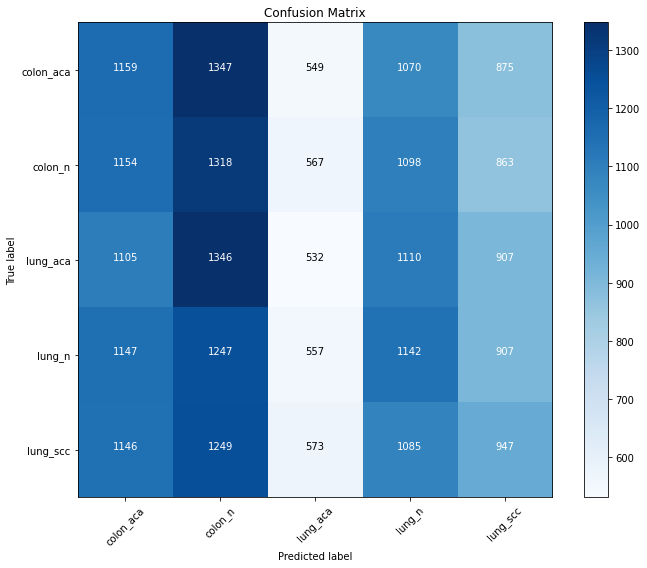

In [89]:
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [90]:
resnet50.save('resnet50.h5')

In [94]:
loaded_model = tf.keras.models.load_model('/kaggle/working/resnet50.h5',compile=False)
print("Model loaded successfully.")



Model loaded successfully.


In [96]:
def predict_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    
    class_names = list(train_generator_resnet.class_indices.keys())
    predicted_class_name = class_names[predicted_class[0]]
    
    plt.imshow(img_array[0])
    plt.title(f'Predicted: {predicted_class_name}')
    plt.axis('off')
    plt.show()


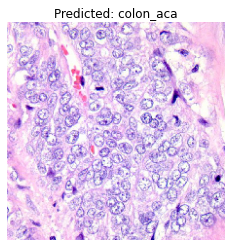

In [97]:
sample_image_path = '/kaggle/input/lc2500/lung_image_sets/colon_aca/colonca1.jpeg'  
predict_image(sample_image_path, loaded_model)


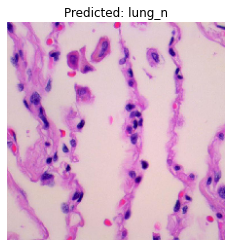

In [101]:
sample_image_path = '/kaggle/input/lc2500/lung_image_sets/lung_n/lungn1.jpeg'  
predict_image(sample_image_path, loaded_model)